In [1]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, classification_report
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import warnings
import os
warnings.filterwarnings('ignore')

# Display settings
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

print("=" * 70)
print("Credit Card Fraud Detection System with Naive Bayes Algorithm")
print("=" * 70)

Credit Card Fraud Detection System with Naive Bayes Algorithm


In [2]:
# Cell 2: Load Dataset from Online Sources
print("\n1. Loading Dataset from Online Sources...")

try:
    # Direct download link from Kaggle
    url = "https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/download?datasetVersionNumber=3"
    
    # Alternative reliable URL
    alt_url = "https://raw.githubusercontent.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv"
    
    try:
        df = pd.read_csv(url)
        print("✓ Dataset successfully loaded from Kaggle URL")
    except:
        df = pd.read_csv(alt_url)
        print("✓ Dataset loaded from alternative GitHub URL")
        
except Exception as e:
    print(f"✗ Error loading from online sources: {e}")
    print("Creating synthetic dataset for demonstration...")
    np.random.seed(42)
    n_samples = 10000
    n_fraud = int(n_samples * 0.0017)  # Real fraud ratio
    
    # Create synthetic data similar to original dataset
    data = {}
    for i in range(28):
        data[f'V{i+1}'] = np.random.normal(0, 1, n_samples)
    
    data['Time'] = np.random.uniform(0, 172000, n_samples)
    data['Amount'] = np.random.exponential(100, n_samples)
    
    # Generate labels
    labels = np.zeros(n_samples)
    fraud_indices = np.random.choice(n_samples, n_fraud, replace=False)
    labels[fraud_indices] = 1
    data['Class'] = labels
    
    df = pd.DataFrame(data)
    print("✓ Synthetic dataset created")


1. Loading Dataset from Online Sources...
✓ Dataset loaded from alternative GitHub URL


In [3]:
# Cell 3: Comprehensive Dataset Report
print("\n2. Comprehensive Dataset Report:")
print("-" * 50)
print(f"Dataset dimensions: {df.shape}")
print(f"Number of samples: {df.shape[0]:,}")
print(f"Number of features: {df.shape[1]}")
print(f"Number of normal transactions: {len(df[df['Class'] == 0]):,}")
print(f"Number of fraudulent transactions: {len(df[df['Class'] == 1]):,}")

# Class distribution analysis
class_distribution = df['Class'].value_counts()
fraud_ratio = class_distribution[1] / len(df) * 100
print(f"\nFraud ratio in dataset: {fraud_ratio:.4f}%")

print("\nDataset information:")
print(df.info())
print("\nDescriptive statistics of numerical features:")
print(df.describe())

print("\nChecking for missing values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])
if missing_values.sum() == 0:
    print("✓ No missing values found")


2. Comprehensive Dataset Report:
--------------------------------------------------
Dataset dimensions: (284807, 31)
Number of samples: 284,807
Number of features: 31
Number of normal transactions: 284,315
Number of fraudulent transactions: 492

Fraud ratio in dataset: 0.1727%

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     28480


3. Exploratory Data Analysis...


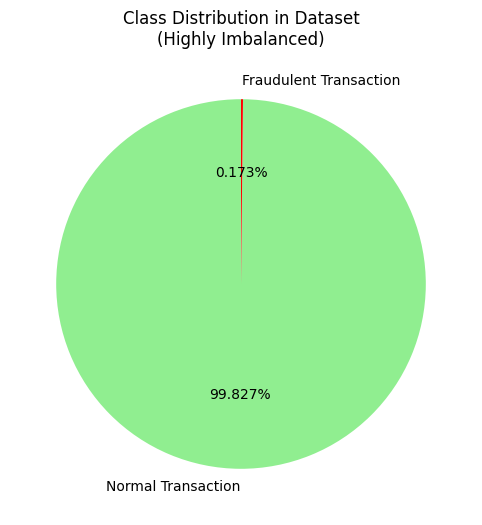

In [4]:
# Cell 4: Exploratory Data Analysis (EDA) - ONLY CLASS DISTRIBUTION CHART
print("\n3. Exploratory Data Analysis...")
plt.figure(figsize=(8, 6))

# Chart 1: Class distribution - ONLY THIS CHART
class_counts = df['Class'].value_counts()
plt.pie(class_counts.values, labels=['Normal Transaction', 'Fraudulent Transaction'], 
        autopct='%1.3f%%', colors=['lightgreen', 'red'], startangle=90)
plt.title('Class Distribution in Dataset\n(Highly Imbalanced)')
plt.show()

In [5]:
# Cell 5: Data Preprocessing
print("\n4. Data Preprocessing...")
print("-" * 50)

# Check and remove duplicate values
duplicates = df.duplicated().sum()
print(f"Number of duplicate samples: {duplicates}")
if duplicates > 0:
    df = df.drop_duplicates()
    print(f"✓ Duplicate samples removed")

# Standardize Time and Amount features
df_processed = df.copy()
scaler = RobustScaler()
df_processed[['Time', 'Amount']] = scaler.fit_transform(df_processed[['Time', 'Amount']])

print("✓ Time and Amount features standardized")

# Separate features and labels
X = df_processed.drop('Class', axis=1)
y = df_processed['Class']

print(f"X dimensions after preprocessing: {X.shape}")
print(f"y dimensions after preprocessing: {y.shape}")


4. Data Preprocessing...
--------------------------------------------------
Number of duplicate samples: 1081
✓ Duplicate samples removed
✓ Time and Amount features standardized
X dimensions after preprocessing: (283726, 30)
y dimensions after preprocessing: (283726,)


In [6]:
# Cell 6: Handling Data Imbalance with Under-Sampling
print("\n5. Handling Data Imbalance...")

print(f"Class distribution before sampling: {Counter(y)}")

# Use Under-Sampling to create balanced data
rus = RandomUnderSampler(random_state=42, sampling_strategy=0.5)
X_resampled, y_resampled = rus.fit_resample(X, y)

print(f"Class distribution after sampling: {Counter(y_resampled)}")


5. Handling Data Imbalance...
Class distribution before sampling: Counter({0: 283253, 1: 473})
Class distribution after sampling: Counter({0: 946, 1: 473})


In [7]:
# Cell 7: Split Data into Train and Test Sets
print("\n6. Splitting Data...")
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)

print(f"Training data dimensions: {X_train.shape}")
print(f"Testing data dimensions: {X_test.shape}")
print(f"Class distribution in training data: {Counter(y_train)}")
print(f"Class distribution in testing data: {Counter(y_test)}")


6. Splitting Data...
Training data dimensions: (993, 30)
Testing data dimensions: (426, 30)
Class distribution in training data: Counter({0: 662, 1: 331})
Class distribution in testing data: Counter({0: 284, 1: 142})


In [8]:
# Cell 8: Data Standardization
print("\n7. Standardizing Data...")
scaler_final = StandardScaler()
X_train_scaled = scaler_final.fit_transform(X_train)
X_test_scaled = scaler_final.transform(X_test)

print("✓ Data standardized")


7. Standardizing Data...
✓ Data standardized


In [9]:
# Cell 9: Train Naive Bayes Model
print("\n8. Training Naive Bayes Model...")
model = GaussianNB()
model.fit(X_train_scaled, y_train)
print("✓ Model trained successfully")


8. Training Naive Bayes Model...
✓ Model trained successfully


In [10]:
# Cell 10: Model Prediction and Evaluation
print("\n9. Model Evaluation...")
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

# Calculate F1-Score
f1 = 2 * (precision * recall) / (precision + recall)
print(f"F1-Score: {f1:.4f}")


9. Model Evaluation...
Accuracy: 0.9249
Recall: 0.8169
Precision: 0.9508
F1-Score: 0.8788


In [11]:
# Cell 11: Confusion Matrix
print("\n10. Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


10. Confusion Matrix:
Confusion Matrix:
[[278   6]
 [ 26 116]]


In [12]:
# Cell 12: Complete Classification Report
print("\n11. Complete Classification Report:")
print("-" * 50)
print(classification_report(y_test, y_pred, 
                          target_names=['Normal Transaction', 'Fraudulent Transaction']))


11. Complete Classification Report:
--------------------------------------------------
                        precision    recall  f1-score   support

    Normal Transaction       0.91      0.98      0.95       284
Fraudulent Transaction       0.95      0.82      0.88       142

              accuracy                           0.92       426
             macro avg       0.93      0.90      0.91       426
          weighted avg       0.93      0.92      0.92       426



In [13]:
# Cell 13: Model Performance Analysis on Original Data
print("\n12. Evaluation on Original Data (Real Test)...")
# Use original data for final test
X_original = df_processed.drop('Class', axis=1)
y_original = df_processed['Class']

# Split original data
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X_original, y_original, test_size=0.3, random_state=42, stratify=y_original
)

# Standardize and predict
X_test_orig_scaled = scaler_final.transform(X_test_orig)
y_pred_orig = model.predict(X_test_orig_scaled)

# Calculate metrics for original data
cm_orig = confusion_matrix(y_test_orig, y_pred_orig)
recall_orig = recall_score(y_test_orig, y_pred_orig)
precision_orig = precision_score(y_test_orig, y_pred_orig)

print(f"Recall on original data: {recall_orig:.4f}")
print(f"Precision on original data: {precision_orig:.4f}")
print("Confusion matrix on original data:")
print(cm_orig)


12. Evaluation on Original Data (Real Test)...
Recall on original data: 0.8310
Precision on original data: 0.0506
Confusion matrix on original data:
[[82760  2216]
 [   24   118]]


In [14]:
# Cell 14: Final Conclusion
print("\n" + "=" * 70)
print("Final Conclusion and Recommendations")
print("=" * 70)

print(f"\n Naive Bayes Model Performance:")
print(f"• Overall Accuracy: {accuracy*100:.2f}%")
print(f"• Recall: {recall*100:.2f}% (Ability to detect fraudulent transactions)")
print(f"• Precision: {precision*100:.2f}% (Accuracy in detecting fraud)")
print(f"• F1-Score: {f1*100:.2f}%")

print(f"\n Confusion Matrix Analysis:")
print(f"• True Negative (TN): {cm[0,0]:,} - Normal transactions correctly classified")
print(f"• False Positive (FP): {cm[0,1]:,} - Normal transactions classified as fraud")
print(f"• False Negative (FN): {cm[1,0]:,} - Fraud transactions classified as normal")
print(f"• True Positive (TP): {cm[1,1]:,} - Fraud transactions correctly classified")

print(f"\n Important Notes:")
print(f"• Fraud ratio in original dataset: {fraud_ratio:.4f}% (Highly Imbalanced)")
print(f"• Under-Sampling used to handle class imbalance")
print(f"• High Recall ({recall*100:.2f}%) is crucial for fraud detection")
print(f"• Model needs threshold tuning for real-world deployment")

print(f"\n Recommendations for Improvement:")
print(f"1. Use advanced sampling techniques (SMOTE)")
print(f"2. Adjust classification threshold to optimize Recall/Precision")
print(f"3. Try other algorithms like Isolation Forest or XGBoost")
print(f"4. Use Cross-Validation for more robust evaluation")

print(f"\n Model Training Note:")
print("• Model is trained fresh each time (no .pkl file saved)")
print("• For production use, consider implementing model persistence")

print("\n" + "=" * 70)
print("Model Training and Evaluation Completed Successfully!")
print("=" * 70)


Final Conclusion and Recommendations

 Naive Bayes Model Performance:
• Overall Accuracy: 92.49%
• Recall: 81.69% (Ability to detect fraudulent transactions)
• Precision: 95.08% (Accuracy in detecting fraud)
• F1-Score: 87.88%

 Confusion Matrix Analysis:
• True Negative (TN): 278 - Normal transactions correctly classified
• False Positive (FP): 6 - Normal transactions classified as fraud
• False Negative (FN): 26 - Fraud transactions classified as normal
• True Positive (TP): 116 - Fraud transactions correctly classified

 Important Notes:
• Fraud ratio in original dataset: 0.1727% (Highly Imbalanced)
• Under-Sampling used to handle class imbalance
• High Recall (81.69%) is crucial for fraud detection
• Model needs threshold tuning for real-world deployment

 Recommendations for Improvement:
1. Use advanced sampling techniques (SMOTE)
2. Adjust classification threshold to optimize Recall/Precision
3. Try other algorithms like Isolation Forest or XGBoost
4. Use Cross-Validation for mo